## Implementing your own model

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")
from torch_geometric.loader import DataLoader

sys.path.append("../")
from spikeometric.models import BaseModel
from spikeometric.datasets import NormalGenerator

If you want to use simulate using a model that is not already implemented in the package, you can define your own by subclassing the `BaseModel` and implementing the `input`, `nonlinearity` and `emit_spikes` methods. If you also want to include a filter, you can do so by providing an
implementation of the `connectivity_filter`. 

In this example, we will implement model that has a refractory period like the one you find in the `BernoulliGLM` model, uses the rectifier non-linearity like `RectifierLNP` and has a multidimensional stimulus filter.

In short we want to compute spikes by the following sequence of equations:

1. $$g_i(t+1) = \sum_{j \in \mathcal{N}(i)\cup \{i\}} \mathbf{W}_{j, i} \cdot \mathbf{x}_j + \mathbf{k}\cdot \mathbb{f_i}(t+1)$$
2. $$\mu_i(t+1) = \lambda_0[g_i(t+1) - \theta]_+$$
3. $$x_i(t+1) = \text{Pois}(\mu_i(t+1))$$

In step 1, $\mathbf{W}_{j, i}$ holds the synaptic weights between neuron $j$ and $i$ over a fixed number of time steps $T$ (including self-edges that are self-inhibitory for the refractory periods), $\mathbf{x}_j$ is the spike history of $j$ over the past $T$ time steps, $\mathbf{k}$ is the stimulus filter and $\mathbf{f}_i(t+1)$ is the stimulus to $i$ at time step $t+1$.

In step 2, $\lambda_0$ scales the expected spike rate and $\theta$ is the threshold input needed for the neurons to have non-zero expected firing rate.

In step 3, $\text{Pois}$ is the Poission distribution.

## Implementation
We will describe the implementation process in a step by step fashion, first making the constructor, followed by the `connectivity_filter` and `stimulus_filter` methods before we finish off with the three essential `input`, `non_linearity` and `emit_spikes` methods.

### Constructor
Let's start by making a constructor that sets our arguments as parameters or buffers according to whether we want the them to be tunable or not.

We need a few parameters:
1. $\lambda_0$, the scaling of the expected spike rate
2. $\theta$, the threshold input
3. $\Delta t$, the length of the time step in milliseconds
4. $T$, the number of time steps to consider back in time 
4. $r$, a function that determines the recfractory time course
5. $w$, a function that determines the time course of the synaptic weights
6. $k$, a function that determines the stimulus filter


Note that, while using functions to specify the filters is convenient, they will not be part of the model's state dict and so can't be saved and loaded like tensors can. They also can't be tuned.

In [2]:
def __init__(self, lambda_0: float, theta: float, dt: float, T: int, r: callable, w: callable, k: callable, rng=None):
    super(self).__init__()
    # Buffers
    T = T / dt # Convert to number of time steps
    self.register_buffer("T", torch.tensor(T, dtype=torch.int))
    self.register_buffer("dt", torch.tensor(dt, dtype=torch.float32))

    # Parameters
    self.register_parameter("lambda_0", torch.nn.Parameter(torch.tensor(lambda_0, dtype=torch.float32)))
    self.register_parameter("theta", torch.nn.Parameter(torch.tensor(theta, dtype=torch.float32)))

    # Functions
    self.r = r
    self.w = w
    self.k = k

    # RNG
    self._rng = rng if rng is not None else torch.Generator()

    self.requires_grad_(False) # This is set so that the model does not compute gradients by default.

The buffers are used to store attributes that we want to be part of the state dict but which are not tunable. The parameters __are__ tunable, but since we don't want to compute gradients when we are simulating (this takes a lot of memory and time), gradients are turned off by default with `self.requires_grad_(False)`.

### Connectivity filter
The `connectivity_filter` method lets us expand the synaptic weights to include a time dimension. It should take two arguments, the weights `W0` and the `edge_index` and should return a connectivity filter tensor `W` of dimension `[n_edges, T]` where the element `W[i, t]` should tell us how much a spike at time step `t-T` before the present should be weighted. 

In our model there will be two types of edges: the coupling edges and the refractory edges. The coupling edges hold the strength and time evolution of synaptic connections and the refractory edges determines the self-inhibition during the refractory period.

Based on the `edge_index` we split the edges into coupling and refractory and make use of the `r` and `epsilon` functions we pass to the model to compute the time course of the refractory and coupling edges. They are flipped to get the weights associated with the last time step in the last column.

In [6]:
def connectivity_filter(self, W0: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
    i, j = edge_index # Split the edge index in source and target neurons
    is_self_edge = i == j # Boolean mask of self-edges

    # Time steps going back T time steps
    t = torch.arange(self.T)

    refractory_edges = self.r(t).repeat(is_self_edge.sum(), 1) # Refractory edges [n_self_edges, T]
    coupling_edges = W0[~is_self_edge].unsqueeze(1) * self.w(t)         # Coupling edges [n_edges - n_self_edges, T]

    W = torch.zeros((W0.shape[0], self.T))
    W[is_self_edge] = refractory_edges
    W[~is_self_edge] = coupling_edges

    return W.flip(1)

### Stimulus filter
We want the model to handle a multidimensional stimulus given to some of the neurons, and must implement a `stimulus_filter` method to determine how this stimulus will be integrated into an input. The function `k` that we pass to the model will help us with this. Note that we are assuming that all targeted neurons receive the same stimulus and that they have the same stimulus filter.

In [7]:
def stimulus_filter(self, stimulus: torch.Tensor) -> torch.Tensor:
    return torch.sum(stimulus*self.k(torch.arange(stimulus.shape[0])))

### Input
The neurons will receive synaptic input and stimulus input. Both the `synaptic_input` and the `stimulus_input` methods are already implemented in the `BaseModel`. All we need is to call them.

In [8]:
def input(self, edge_index: torch.Tensor, W: torch.Tensor, state: torch.Tensor, t=-1, stimulus_mask: torch.Tensor = False) -> torch.Tensor:
    return self.synaptic_input(edge_index, W, state) + self.stimulus_input(t, stimulus_mask)

### Non-linearity
After we have collected the input to the neurons, we need to apply a non-linearity to it. In this case, we use a rectified linear non-linearity. The rate is scaled by the time step to ensure that increasing the resolution of the simulation doesn't artificially increase the firing rate.

In [9]:
def non_linearity(self, input: torch.Tensor) -> torch.Tensor:
    return self.lambda_0*torch.relu(input - self.theta) * self.dt

### Emitting spikes
Finally, we want to use Poisson spiking.

In [10]:
def emit_spikes(self, rates: torch.Tensor) -> torch.Tensor:
    return torch.poisson(rates, generator=self._rng)

## Testing the model
Let's now put this all together into a class and run a few simulations to see how it behaves.

In [6]:
class FilRectLNP(BaseModel):
    def __init__(self, lambda_0: float, theta: float, dt: float, T: int, r: callable, w: callable, k: callable, rng=None):
        super().__init__()
        # Buffers
        T = T / dt
        self.register_buffer("T", torch.tensor(T, dtype=torch.int))
        self.register_buffer("dt", torch.tensor(dt, dtype=torch.float32))

        # Parameters
        self.register_parameter("lambda_0", torch.nn.Parameter(torch.tensor(lambda_0, dtype=torch.float32)))
        self.register_parameter("theta", torch.nn.Parameter(torch.tensor(theta, dtype=torch.float32)))

        # Functions
        self.r = r
        self.w = w
        self.k = k

        # RNG
        self._rng = rng if rng is not None else torch.Generator()

        self.requires_grad_(False) # This is set so that the model does not compute gradients by default.

    def connectivity_filter(self, W0: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        i, j = edge_index # Split the edge index in source and target neurons
        is_self_edge = i == j # Boolean mask of self-edges

        # Time steps going back T time steps
        t = torch.arange(self.T)

        refractory_edges = self.r(t).repeat(is_self_edge.sum(), 1) # Refractory edges [n_self_edges, T]
        coupling_edges = W0[~is_self_edge].unsqueeze(1) * self.w(t)         # Coupling edges [n_edges - n_self_edges, T]

        W = torch.zeros((W0.shape[0], self.T))
        W[is_self_edge] = refractory_edges
        W[~is_self_edge] = coupling_edges

        return W.flip(1), edge_index

    def stimulus_filter(self, stimulus: torch.Tensor) -> torch.Tensor:
        return torch.sum(stimulus*self.k(torch.arange(stimulus.shape[0])))
    
    def input(self, edge_index: torch.Tensor, W: torch.Tensor, state: torch.Tensor, t=-1, stimulus_mask: torch.Tensor = False) -> torch.Tensor:
        return self.synaptic_input(edge_index, W, state) + self.stimulus_input(t, stimulus_mask)

    def non_linearity(self, input: torch.Tensor) -> torch.Tensor:
        return self.lambda_0*torch.relu(input - self.theta) * self.dt
    
    def emit_spikes(self, rates: torch.Tensor) -> torch.Tensor:
        return torch.poisson(rates, generator=self._rng)

We'll run our model on a dataset of 10 networks with 50 neurons each, with weights drawn from a glorot normal distribution. There are an equal amount of exciitatory and inhibitory neurons, and the networks are 50% sparse.

For the filters we'll use exponential filters both for the synaptic weights and the stimulus filter. The stimulus will be noisy periodic in 10 frequency bins with a 20 ms stimulus every 100 ms. 

In [9]:
n_neurons = 50
test_data = NormalGenerator(n_neurons, mean=0, std=0.5, glorot=True).generate(10)
loader = DataLoader(test_data, batch_size=5, shuffle=False)

def r(t):
    return -1000.*(t < 2) + -1000*torch.exp(-2*(t-2))*(t >= 2)*(t<5)

def w(t):
    return torch.exp(-t/2)

def k(f):
    return torch.exp(-f/5)

def stimulus(t):
    return 0.1*torch.rand(5) * (t % 100 < 20)

model = FilRectLNP(lambda_0=1, theta=-0.01, dt=1, T=20, r=r, w=w, k=k)
model.add_stimulus(stimulus)

As we don't know what kind of behaviour these parameters will lead to a priori, let's tune them so that the network has an average firing rate of about 10 Hz.

In [10]:
for data in loader:
    model.tune(data, firing_rate=10., lr=1e-4, n_epochs=100, n_steps=500)

Tuning... fr=10.10482: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


The model seems to converge, so we can run the simulation with the stimulus and plot the data

In [11]:
n_steps=10000
results = torch.zeros((50*10, n_steps))
model.add_stimulus(stimulus)
for i, batch in enumerate(loader):
    batch.stimulus_mask = torch.isin(torch.arange(batch.num_nodes), torch.randperm(batch.num_nodes)[:int(batch.num_nodes*0.1)])
    results[i*batch.num_nodes:(i+1)*batch.num_nodes] = model.simulate(batch, n_steps=n_steps)

100%|██████████| 10000/10000 [00:02<00:00, 4222.05it/s]


We'll plot the PTSH, a raster plot and the ISIH to get an overview of what the data looks like. Since the stimulus is periodic we'll plot the average across cycles.

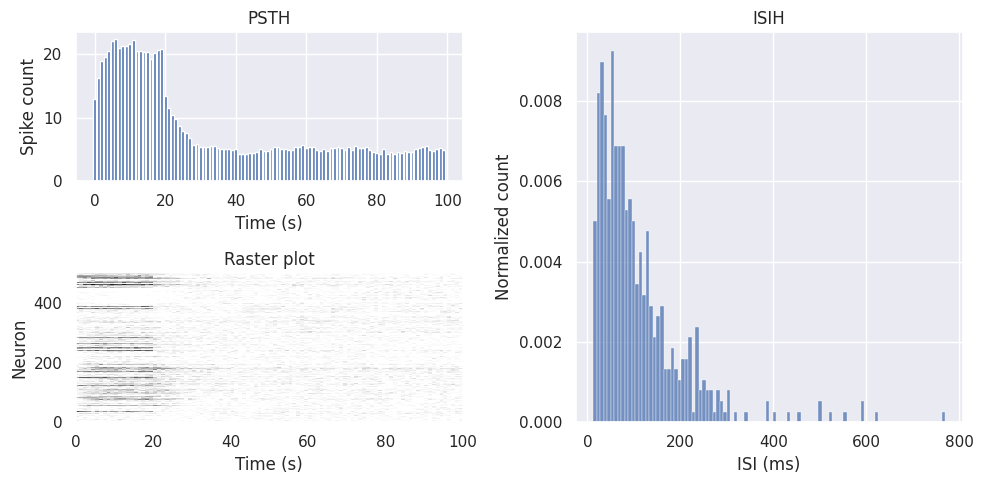

In [12]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

time_window = 1000 # ms
n_neurons = 50 # one network
stim_period = 100 # ms (period of the stimulus)
time_bin = 10 # ms (bin size for the PSTH)

binned_firings = results.reshape(results.shape[0], -1, stim_period).mean(1)
isi = model.dt / results.mean(1)

ax1.bar(torch.arange(stim_period), binned_firings.sum(0))
ax1.set_title('PSTH')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Spike count')

ax2.pcolormesh(binned_firings, cmap='binary')
ax2.set_title('Raster plot')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Neuron')

sns.histplot(isi, ax=ax3, stat='density', bins=100)
ax3.set_title('ISIH')
ax3.set_ylabel('Normalized count')
ax3.set_xlabel('ISI (ms)')

plt.tight_layout()
plt.show()

We can clearly see the effect of the stimulus both on the PTSH and the raster plot. We can also see that the neurons are refractory after they are triggered by the stimulus, a feature we built into the model.